## Loading data using GEE

In [2]:
import ee

ee.Authenticate()
ee.Initialize(project='sample-mission-424819')

/home/hongjin_zhu/anaconda3/envs/energygrid-predict/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


### Sentinel2 Cloudscore+

In [3]:
import pandas as pd

ROI = ee.Geometry.Point([71.4333, 27.5833])
START = '2021-07-01'
END   = '2021-08-01'
QA_BAND = 'cs_cdf'

s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(ROI).filterDate(START, END)

csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED') \
    .filterBounds(ROI).filterDate(START, END)

linked = s2.linkCollection(csPlus, [QA_BAND]) \
    .map(lambda img: img.set({
        'time_start_utc': img.date().format('YYYY-MM-dd HH:mm:ss'),
        'cloud_score_mean': img.select(QA_BAND).reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=ROI.buffer(500),
            scale=20
        ).get(QA_BAND)
    }))

s2_list = linked.aggregate_array('system:time_start').getInfo()
s2_fc = linked.map(lambda img: ee.Feature(None, img.toDictionary(['time_start_utc', 'cloud_score_mean'])))
s2_pd = pd.DataFrame(s2_fc.aggregate_array('time_start_utc').getInfo(), columns=['time_start_utc'])
s2_pd['cloud_score_mean'] = s2_fc.aggregate_array('cloud_score_mean').getInfo()

s2_pd.to_csv('Bhadla_S2_csCDF_July2021.csv', index=False)
s2_pd

,time_start_utc,cloud_score_mean
0,2021-07-04 06:01:32,0.867091
1,2021-07-09 06:01:31,0.858616
2,2021-07-14 06:01:32,0.653549
3,2021-07-19 06:01:31,0.725574
4,2021-07-24 06:01:33,0.313895
5,2021-07-29 06:01:31,0.094506


### Sentinel-1 GRD

In [4]:
import ee, pandas as pd

ROI   = ee.Geometry.Point([71.4333, 27.5833])  # Bhadla
START = '2021-07-01'
END   = '2021-08-01'

def _s1_preprocess(img):
    angle = img.select('angle')
    mask  = angle.gt(30).And(angle.lt(45))
    return (img.updateMask(mask)
               .select(['VV','VH','angle'])
               .copyProperties(img, img.propertyNames()))

# S1 GRD (VV/VH), IW, 10 m
s1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
      .filterBounds(ROI)
      .filterDate(START, END)
      .filter(ee.Filter.eq('instrumentMode', 'IW'))
      .filter(ee.Filter.eq('resolution_meters', 10))
      .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
      .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
      .map(_s1_preprocess))

# Convert per-image VV/VH from dB -> linear, reduce in linear, convert back to dB
def _roi_stats_linear_then_db(img):
    vv_lin = ee.Image(10).pow(img.select('VV').divide(10)).rename('VV_lin')
    vh_lin = ee.Image(10).pow(img.select('VH').divide(10)).rename('VH_lin')
    tmp = img.addBands([vv_lin, vh_lin])

    props = tmp.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ROI.buffer(500),
        scale=10,
        bestEffort=True,
        maxPixels=1e13
    )

    vv_lin_mean = ee.Number(props.get('VV_lin'))
    vh_lin_mean = ee.Number(props.get('VH_lin'))

    # convert linear mean back to dB (safe: input is positive)
    vv_db = ee.Number(10).multiply(vv_lin_mean.log10())
    vh_db = ee.Number(10).multiply(vh_lin_mean.log10())

    return img.set({
        'time_start_utc': img.date().format('YYYY-MM-dd HH:mm:ss'),
        'VV_dB': vv_db,
        'VH_dB': vh_db,
        'orbit_pass': img.get('orbitProperties_pass'),
        'relative_orbit': img.get('relativeOrbitNumber_start')
    })

s1_feats = s1.map(_roi_stats_linear_then_db).filter(ee.Filter.notNull(['VV_dB','VH_dB']))

# to pandas
times   = s1_feats.aggregate_array('time_start_utc').getInfo()
vv_vals = s1_feats.aggregate_array('VV_dB').getInfo()
vh_vals = s1_feats.aggregate_array('VH_dB').getInfo()
pass_es = s1_feats.aggregate_array('orbit_pass').getInfo()

df_s1 = pd.DataFrame({
    'time_start_utc': times,
    'VV_dB': vv_vals,
    'VH_dB': vh_vals,
    'orbit_pass': pass_es
}).sort_values('time_start_utc')

# ratio/contrast
df_s1['VV_minus_VH_dB'] = df_s1['VV_dB'] - df_s1['VH_dB']

df_s1.to_csv('Bhadla_S1_VVVH_July2021.csv', index=False)
df_s1

,time_start_utc,VV_dB,VH_dB,orbit_pass,VV_minus_VH_dB
0,2021-07-01 01:17:24,-15.006301,-22.753879,DESCENDING,7.747578
1,2021-07-05 13:19:41,-18.020921,-23.703735,ASCENDING,5.682814
2,2021-07-08 01:08:58,-18.388842,-23.971294,DESCENDING,5.582452
3,2021-07-13 01:17:25,-10.324088,-21.205968,DESCENDING,10.881880
4,2021-07-17 13:19:42,-18.201023,-24.116195,ASCENDING,5.915173
5,2021-07-20 01:08:58,-18.190099,-23.947323,DESCENDING,5.757224
6,2021-07-29 13:19:42,-18.114609,-23.839649,ASCENDING,5.725040


### HLSL30

In [5]:
ROI   = ee.Geometry.Point([71.4333, 27.5833])  # Bhadla
START = '2021-07-01'
END   = '2021-08-01'
buf_m = 1500  # wider buffer so pixels survive masks

hlsl30 = (ee.ImageCollection('NASA/HLS/HLSL30/v002')
          .filterBounds(ROI)
          .filterDate(START, END))

def _add_ndvi(img):
    # Handle B04/B05 vs B4/B5 variants
    bn = img.bandNames()
    red_name = ee.Algorithms.If(bn.contains('B04'), 'B04', 'B4')
    nir_name = ee.Algorithms.If(bn.contains('B05'), 'B05', 'B5')
    red = img.select(ee.String(red_name)).multiply(0.0001)
    nir = img.select(ee.String(nir_name)).multiply(0.0001)
    # guard against 0 in denominator
    ndvi = nir.subtract(red).divide(nir.add(red).where(nir.add(red).eq(0), 1)).rename('NDVI')
    return img.addBands(ndvi)

def _add_cloud_frac(img):
    # Cloud pixels are Fmask == 4; mean of 0/1 is fraction cloudy
    cloud_frac = img.select('Fmask').eq(4).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ROI.buffer(buf_m),
        scale=30,
        bestEffort=True,
        maxPixels=1e13,
        tileScale=2
    ).get('Fmask')
    return img.set({'cloud_frac': cloud_frac})

def _to_feats(img):
    props = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ROI.buffer(buf_m),
        scale=30,
        bestEffort=True,
        maxPixels=1e13,
        tileScale=2
    )
    return img.set({
        'time_start_utc': img.date().format('YYYY-MM-dd HH:mm:ss'),
        'NDVI': props.get('NDVI')
    })

hls_proc = (hlsl30
            .map(_add_ndvi)
            .map(_add_cloud_frac)
            .map(_to_feats))

# pull everything before inspecting
times = hls_proc.aggregate_array('time_start_utc').getInfo()
ndvi  = hls_proc.aggregate_array('NDVI').getInfo()
cld   = hls_proc.aggregate_array('cloud_frac').getInfo()

import numpy as np
df_hls = pd.DataFrame({
    'time_start_utc': times,
    'NDVI': ndvi,
    'cloud_frac': cld
}).sort_values('time_start_utc')

# Keep rows with valid NDVI
df_hls = df_hls[df_hls['NDVI'].notnull()]
df_hls = df_hls[(df_hls['cloud_frac'].isnull()) | (df_hls['cloud_frac'] < 0.9)]

df_hls.to_csv('Bhadla_HLSL30_NDVI_July2021.csv', index=False)
df_hls.head(10)

,time_start_utc,NDVI,cloud_frac
0,2021-07-02 05:43:52,0.084552,0
1,2021-07-18 05:43:30,0.093740,0
2,2021-07-18 05:43:54,0.093740,0


### MODIS MOD09GA

In [6]:
import ee, pandas as pd

ROI    = ee.Geometry.Point([71.4333, 27.5833])  # Bhadla
START  = '2021-07-01'
END    = '2021-08-01'
BUF_M  = 500

# MODIS Surface Reflectance (daily, 500 m; state_1km -> 1 km QA)
modis = (ee.ImageCollection('MODIS/006/MOD09GA')
         .filterBounds(ROI)
         .filterDate(START, END)
         .select(['state_1km', 'QC_500m']))

def _add_cloud_bits(img):
    s = img.select('state_1km')

    # Bits 0–1: Cloud state (00=clear, 01=cloudy, 10=mixed, 11=not set)
    cloud_state = s.bitwiseAnd(3)  # mask 0b11
    is_cloudy_or_mixed = cloud_state.eq(1).Or(cloud_state.eq(2))

    # Bit 2: Cloud shadow (1=shadow)
    is_shadow = s.bitwiseAnd(1 << 2).gt(0)

    cloud_mask = is_cloudy_or_mixed.Or(is_shadow).rename('cloud_or_shadow')

    return img.addBands(cloud_mask)

def _reduce_roi(img):
    props = img.select(['cloud_or_shadow']).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ROI.buffer(BUF_M),
        scale=500,            # 500 m matches MOD09GA surface bands; state_1km is upsampled
        bestEffort=True,
        maxPixels=1e13,
        tileScale=2
    )

    return img.set({
        'time_start_utc': img.date().format('YYYY-MM-dd HH:mm:ss'),
        'cloud_frac': props.get('cloud_or_shadow')
    })

modis_feats = (modis
               .map(_add_cloud_bits)
               .map(_reduce_roi)
               .filter(ee.Filter.notNull(['cloud_frac'])))

times = modis_feats.aggregate_array('time_start_utc').getInfo()
cfrac = modis_feats.aggregate_array('cloud_frac').getInfo()

df_modis = pd.DataFrame({
    'time_start_utc': times,
    'cloud_frac': cfrac
}).sort_values('time_start_utc')

df_modis.to_csv('Bhadla_MOD09GA_cloud_July2021.csv', index=False)

df_modis

/home/hongjin_zhu/anaconda3/envs/energygrid-predict/lib/python3.11/site-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MOD09GA! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD09GA

  warnings.warn(warning, category=DeprecationWarning)


,time_start_utc,cloud_frac
0,2021-07-01 00:00:00,0
1,2021-07-03 00:00:00,0
2,2021-07-04 00:00:00,0
3,2021-07-05 00:00:00,0
4,2021-07-06 00:00:00,0
5,2021-07-07 00:00:00,0
6,2021-07-08 00:00:00,0
7,2021-07-09 00:00:00,1
8,2021-07-10 00:00:00,0
9,2021-07-11 00:00:00,1


## `match_utils`

In [7]:
import pandas as pd
from match_utils import MatchSpec, align_many

# 1) ERA5 hourly grid
df_temporal = pd.read_csv("Bhadla_2021-07.csv", parse_dates=["time"]).sort_values("time")

# 2) Satellite tables → normalize to 'time'
df_s2   = pd.read_csv("Bhadla_S2_csCDF_July2021.csv", parse_dates=["time_start_utc"]).rename(columns={"time_start_utc":"time"})
df_s1   = pd.read_csv("Bhadla_S1_VVVH_July2021.csv", parse_dates=["time_start_utc"]).rename(columns={"time_start_utc":"time"})
df_hls  = pd.read_csv("Bhadla_HLSL30_NDVI_July2021.csv", parse_dates=["time_start_utc"]).rename(columns={"time_start_utc":"time"})
df_mod9 = pd.read_csv("Bhadla_MOD09GA_cloud_July2021.csv", parse_dates=["time_start_utc"]).rename(columns={"time_start_utc":"time"})

datasets = {
    "S2_CSPlus": df_s2,
    "S1_VVVH":   df_s1,
    "HLS_NDVI":  df_hls,
    "MOD09GA":   df_mod9,
    # "L8_SR":   df_l8,
    # "VIIRS_CM":df_vcm,
    # "MOD35":   df_m35,
}

specs = [
    MatchSpec(name="S2_CSPlus", time_col="time", value_cols=["cloud_score_mean"], prefix="s2",  how="linear"),
    MatchSpec(name="S1_VVVH",   time_col="time", value_cols=["VV_dB","VH_dB"],   prefix="s1",  how="linear"),
    MatchSpec(name="HLS_NDVI",  time_col="time", value_cols=["NDVI"],            prefix="hls", how="spline", spline_order=3),
    MatchSpec(name="MOD09GA",   time_col="time", value_cols=["cloud_frac"],      prefix="mod09", how="linear"),
    # Example spline on another dataset:
    # MatchSpec(name="L8_SR", time_col="time", value_cols=["NDVI"], prefix="l8", how="spline", spline_order=3),
]

aligned = align_many(df_temporal, datasets, specs, grid_time_col="time")

df_era5_s2_nearest   = aligned["S2_CSPlus__nearest"]
df_era5_s2_linear    = aligned["S2_CSPlus__interp"]      # linear
df_era5_s1_nearest   = aligned["S1_VVVH__nearest"]
df_era5_s1_linear    = aligned["S1_VVVH__interp"]        # linear
df_era5_hls_nearest  = aligned["HLS_NDVI__nearest"]
df_era5_hls_spline   = aligned["HLS_NDVI__interp"]       # spline
df_era5_modis_nearest= aligned["MOD09GA__nearest"]
df_era5_modis_linear = aligned["MOD09GA__interp"]        # linear

## `stats_utils`

In [14]:
out = (
    df_temporal
    .merge(df_era5_s2_linear[["time", "s2__cloud_score_mean"]], on="time", how="left")
    .merge(df_era5_hls_spline[["time", "hls__NDVI"]], on="time", how="left")
)

In [15]:
from stats_utils import corr_matrix
corr = corr_matrix(out, cols=["ssrd", "s2__cloud_score_mean", "hls__NDVI"], time_col="time")
corr

,ssrd,s2__cloud_score_mean,hls__NDVI
ssrd,1.000000,0.082943,-0.087108
s2__cloud_score_mean,0.082943,1.000000,-0.121762
hls__NDVI,-0.087108,-0.121762,1.000000


/mnt/e/CERA/CausalST-forecast/spatiotemporal_match/stats_utils.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return X[x_col].rolling(window).corr(X[y_col])


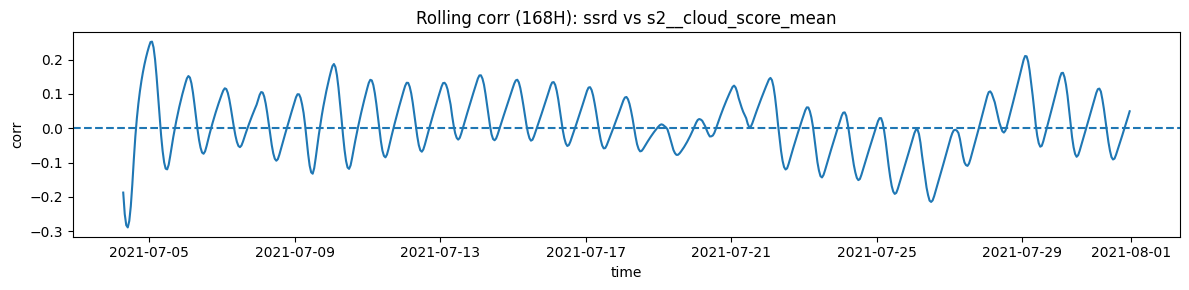

In [16]:
from stats_utils import plot_rolling_corr
plot_rolling_corr(out, x_col="ssrd", y_col="s2__cloud_score_mean", time_col="time", window="168H")

In [17]:
from stats_utils import granger_batch, plot_granger_matrix

pairs = [("q", "cc"), ("cc", "temp")]  # cause -> effect
gdf = granger_batch(out, pairs=pairs, time_col="time", maxlag=6, alpha=0.05, force_diff=None, verbose=True)
display(gdf.sort_values(["cause","effect","lag"]))

# Visualize one pair’s p-values across lags
plot_granger_matrix(gdf, cause="q", effect="cc", title="q → cc (hourly lags)")
plot_granger_matrix(gdf, cause="cc", effect="temp", title="cc → temp (hourly lags)")

,cause,effect,lag,pvalue,significant,best_lag_for_pair,differenced,adf_cause_p,adf_effect_p,maxlag_used,error
1,cc,temp,NaN,NaN,False,False,NaN,NaN,NaN,NaN,"KeyError(""None of [Index(['cc', 'temp'], dtype..."
0,q,cc,NaN,NaN,False,False,NaN,NaN,NaN,NaN,"KeyError(""['cc'] not in index"")"


/mnt/e/CERA/CausalST-forecast/spatiotemporal_match/stats_utils.py:241: UserWarning: No results to plot for this pair.
  warnings.warn("No results to plot for this pair.")
/mnt/e/CERA/CausalST-forecast/spatiotemporal_match/stats_utils.py:241: UserWarning: No results to plot for this pair.
  warnings.warn("No results to plot for this pair.")


/home/hongjin_zhu/anaconda3/envs/energygrid-predict/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


,cause,effect,lag,pvalue,significant,best_lag_for_pair,differenced,adf_cause_p,adf_effect_p,maxlag_used
0,s2__cloud_score_mean,ssrd,1,0.856030,False,False,True,0.77003,0.073408,6
1,s2__cloud_score_mean,ssrd,2,0.523295,False,False,True,0.77003,0.073408,6
2,s2__cloud_score_mean,ssrd,3,0.489134,False,False,True,0.77003,0.073408,6
3,s2__cloud_score_mean,ssrd,4,0.298929,False,False,True,0.77003,0.073408,6
4,s2__cloud_score_mean,ssrd,5,0.294928,False,False,True,0.77003,0.073408,6
5,s2__cloud_score_mean,ssrd,6,0.139009,False,True,True,0.77003,0.073408,6


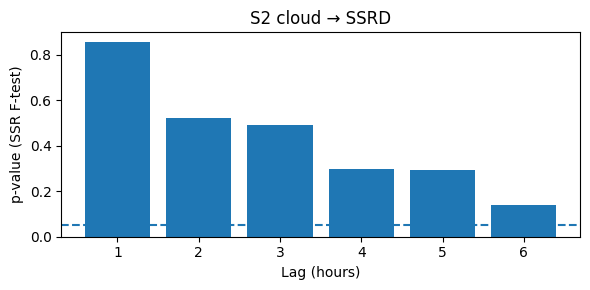

In [18]:
# Does S2 cloud score (s2__cloud_score_mean) help predict ERA5 cloud fraction (if present), or SSRD?
pairs = [("s2__cloud_score_mean", "ssrd")]
gdf2 = granger_batch(out, pairs=pairs, time_col="time", maxlag=6, alpha=0.05)
display(gdf2)
plot_granger_matrix(gdf2, cause="s2__cloud_score_mean", effect="ssrd", title="S2 cloud → SSRD")